# AI-A-2023-Fall PJ1
柳世纯 20307130111
## PART 1

### 回归，拟合sin曲线

生成数据

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
import os

In [8]:
def sin_data_generate(filename: str):
    x_min, x_max = -1 * np.pi, np.pi
    n_samples = 5000
    x = np.random.uniform(x_min, x_max, size=n_samples)
    y_true = np.sin(x)
    # add noise
    noise_scale = 0.05
    y_sample = y_true + np.random.normal(scale=noise_scale, size=n_samples)


    with open(filename, "w", encoding="utf-8", newline="") as output_file:
        csv_writer = csv.writer(output_file)
        csv_writer.writerow(["x", "y"])
        for i in range(n_samples):
            csv_writer.writerow([str(x[i]), str(y_sample[i])])
            
def read_file(filename: str):
    data = pd.read_csv(filename, usecols=[0])
    x = np.array(data.stack()).reshape(-1, 1)
    label = pd.read_csv(filename, usecols=[1])
    y = np.array(label.stack()).reshape(-1, 1)
    return x, y
    

average error: 0.0024728852867563524


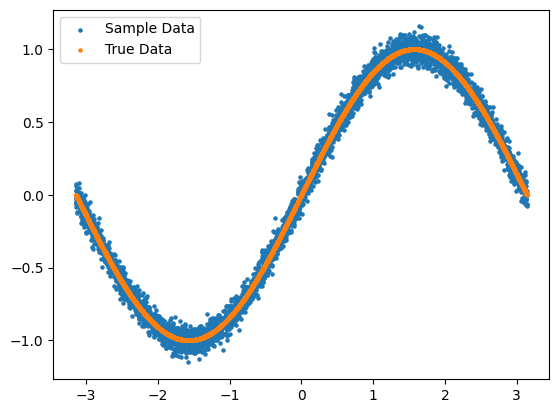

In [25]:
if not os.path.exists('train.csv'): sin_data_generate("train.csv")
x, y = read_file("train.csv")
y_sin = np.sin(x)
avg_error = np.square(y_sin - y).mean()
print("average error:", avg_error)

plt.figure()
plt.scatter(x, y, s=5, label="Sample Data")
plt.scatter(x, y_sin, s=5, label="True Data")
plt.legend()
plt.show()

Layer class

In [2]:
from numpy import ndarray

In [3]:
class Layer:
    def __init__(self):
        pass

    def forward(self, x):
        raise NotImplementedError

    def backward(self, grad):
        raise NotImplementedError


class Linear(Layer):
    def __init__(self, in_dim: int, out_dim: int, last: bool = False):
        super().__init__()
        self._type = "layer"
        # Weights = [−1, +1] / (number of units) or [−1, +1] / sqrt(number of units).
        W = np.random.rand(in_dim, out_dim) * 2 - 1
        self.weight = W / out_dim

        # Bias = [−0.2, +0.2] (Last layer), and [0, −1] (otherwise).
        if last:
            tmp = np.random.rand(1, out_dim) * 2 - 1
            self.bias = tmp * 0.2
        else:
            self.bias = np.random.rand(1, out_dim) - 1

        self.last = last
        self.dw = np.zeros_like(self.weight)
        self.db = np.zeros_like(self.bias)

    def forward(self, x: ndarray) -> ndarray:
        self.x = x
        x1 = x.reshape(x.shape[0], -1)
        val_out = np.matmul(x1, self.weight) + self.bias

        return val_out

    def backward(self, dL_dz):
        # dL_dz为后向传播的输入梯度(1, 1),a是经过激活函数的输出,z是经过线性计算的输出
        x = self.x 
        dz_dw = x.reshape(x.shape[0], -1)

        dL_dw = np.matmul(dz_dw.T, dL_dz)
        dL_db = np.sum(dL_dz, axis=0, keepdims=True) 

        dL_da = np.matmul(dL_dz, np.transpose(self.weight))
        dL_da = dL_da.reshape(x.shape)  
        self.dw += dL_dw
        self.db += dL_db
        return dL_da  


activate

In [4]:
def sigmoid(x: ndarray):
    x_ravel = x.ravel()
    length = len(x_ravel)
    y = []
    for index in range(length):
        if x_ravel[index] >= 0:
            y.append(1.0 / (1 + np.exp(-x_ravel[index])))
        else:
            y.append(np.exp(x_ravel[index]) / (np.exp(x_ravel[index]) + 1))
    return np.array(y).reshape(x.shape)


class Sigmoid(Layer):
    def __init__(self):
        super().__init__()
        self._type = "active"
        pass

    def forward(self, z):
        self.z = z
        a = sigmoid(z)
        return a

    def backward(self, grad_output):
        z = self.z
        a = sigmoid(z)
        return grad_output * a * (1 - a)


class ReLu(Layer):
    def __init__(self):
        super().__init__()
        self._type = "active"
        pass

    def forward(self, z):
        self.z = z
        return np.maximum(z, 0)

    def backward(self, grad_output):
        z = self.z
        z[z <= 0] = 0
        z[z > 0] = 1
        return grad_output * z


loss

In [5]:
def mse_loss(predict: ndarray, label: ndarray):
    loss = np.square(predict - label).mean() / 2
    grad = (predict - label).reshape(1, 1)
    return loss, grad


def softmax(Z):
    A = np.exp(Z)
    return A / np.sum(A, axis=1, keepdims=True)


def softmax_cross_entropy_loss(y: ndarray, label: ndarray):
    predict = softmax(y)
    loss = -np.sum(label * np.log(predict), axis=1)
    grad = (predict - label) / y.shape[0]
    return np.mean(loss), grad

nn

In [6]:
class NeuralNetwork:
    def __init__(self):
        self._layers = []

    def setup_layer(self, layer: Layer):
        self._layers.append(layer)

    def forward(self, input):
        for L in self._layers:
            input = L.forward(input)
        return input

    def backward(self, grad):
        for i in reversed(range(len(self._layers))):
            layer = self._layers[i]
            grad = layer.backward(grad)

    def predict(self, input):
        pre = self.forward(input)
        return pre

    def classify_predict(self, input):
        pre = self.forward(input)
        if pre.ndim == 1:
            return (pre == pre.max()).astype(int)
        return (pre == pre.max(axis=1, keepdims=True)).astype(int)

    def update_parameters(self, learning_rate):
        for layer in self._layers:
            if layer._type == "layer":
                layer.weight = layer.weight - learning_rate * layer.dw
                layer.bias = layer.bias - learning_rate * layer.db
                layer.dw = np.zeros_like(layer.weight)
                layer.db = np.zeros_like(layer.bias)
    
    def save_parameter1(self):
        for i in range(len(self._layers)):
            if self._layers[i]._type == "layer":
                np.savetxt("./weight_sin{}.txt".format(i), self._layers[i].weight)
                np.savetxt("./bias_sin{}.txt".format(i), self._layers[i].bias)

    def load_parameter1(self):
        for i in range(len(self._layers)):
            if self._layers[i]._type == "layer":
                self._layers[i].weight = np.loadtxt("./weight_sin{}.txt".format(i)).reshape(self._layers[i].weight.shape[0], -1)
                self._layers[i].bias = np.loadtxt("./bias_sin{}.txt".format(i)).reshape(self._layers[i].bias.shape[0], -1)

    def save_parameter2(self):
        for i in range(len(self._layers)):
            if self._layers[i]._type == "layer":
                np.savetxt("./W{}.txt".format(i), self._layers[i].weight)
                np.savetxt("./B{}.txt".format(i), self._layers[i].bias)

    def load_parameter2(self):
        for i in range(len(self._layers)):
            if self._layers[i]._type == "layer":
                self._layers[i].weight = np.loadtxt("./W{}.txt".format(i)).reshape(self._layers[i].weight.shape[0], -1)
                self._layers[i].bias = np.loadtxt("./B{}.txt".format(i)).reshape(self._layers[i].bias.shape[0], -1)



train

In [10]:
from tqdm import tqdm

def train(
    nn: NeuralNetwork, XX, YY, loss_function=mse_loss, epochs=2000, learning_rate=1e-2
):
    assert len(XX) == len(YY)  # XX是数据，YY是数据标签
    loss_list = []
    iters = []

    for epoch in tqdm(range(epochs)):
        np.random.seed(1)
        np.random.shuffle(XX)
        np.random.seed(1)
        np.random.shuffle(YY)
        epoch_loss = 0
        # 打乱数据，需要使seed相等否则XX和YY对应不上
        for i in range(0, len(XX)):
            x = np.array(XX[i]).reshape(1, 1)
            label = np.array(YY[i]).reshape(1, 1)
            predict = nn.forward(x)


            loss, grad = loss_function(predict, label)
            epoch_loss += loss
            nn.backward(grad)
            nn.update_parameters(learning_rate)

        epoch_loss = epoch_loss / len(XX)
        loss_list.append(epoch_loss)
        iters.append(epoch + 1)
        print("{} epoch, average error:{}".format(epoch + 1, epoch_loss))

    print("-----save parameters-----")
    nn.save_parameter1()
    plt.figure()
    plt.scatter(iters, loss_list, s=5, label="loss")
    plt.legend()
    plt.show()


run

In [7]:
x, y = read_file("train.csv")

nn = NeuralNetwork()
nn.setup_layer(Linear(1, 100))
nn.setup_layer(Sigmoid())
nn.setup_layer(Linear(100, 1, last=True))


NameError: name 'read_file' is not defined

In [ ]:

epochs = 200
lr = 1e-2
train(nn, x, y, mse_loss, epochs, lr)


拟合后测试平均误差: 0.00011006798489977597


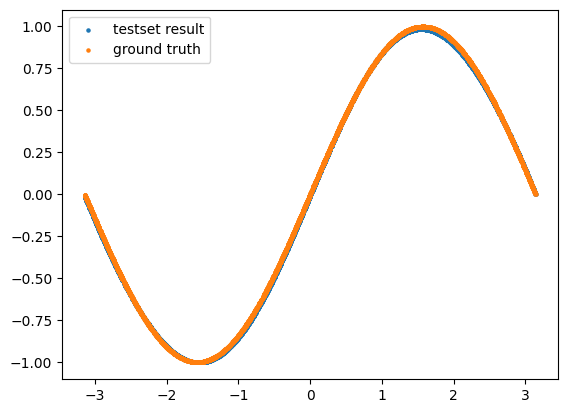

In [11]:
nn.load_parameter1()

x_test, y_test = read_file("test.csv")
pre = nn.predict(x_test)
y_sin = np.sin(x_test)
avg_error = np.square(pre - y_sin).mean()
print("拟合后测试平均误差:", avg_error)

plt.figure()
plt.scatter(x_test, pre, s=5, label="testset result")
plt.scatter(x_test, y_sin, s=5, label="ground truth")
plt.legend()
plt.show()

## 手写汉字分类

In [9]:
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
import os
from sklearn.model_selection import StratifiedShuffleSplit
from tqdm import tqdm

In [10]:
# 将图片转化为1维向量, 标签转化为one-hot向量
def image2vec(path: str):
    x_data = []
    y_data = []
    files = os.listdir(path)
    for i in range(1, len(files) + 1):
        sub_files = os.listdir(path + "/{0}".format(i))
        for j in range(1, len(sub_files) + 1):
            dirpath = path + "/{0}/{1}.bmp".format(i, j)
            img_cv = cv2.imread(dirpath).reshape(1, -1)
            img_cv = np.squeeze(img_cv).tolist()
            x_data.append(img_cv)
            y = [0] * 12
            y[i - 1] = 1
            y_data.append(y)
    return x_data, y_data

In [11]:
def write_data(x_data, y_data, filename: str = "image_data.csv"):
    with open(filename, "w", encoding="utf-8", newline="") as f:
        csv_writer = csv.writer(f)
        csv_writer.writerow(["1d-vector", "class"])
        for i in range(len(x_data)):
            csv_writer.writerow([x_data[i], y_data[i]])
    

# 从csv文件中读出数据
def read_file(filename: str):
    data = pd.read_csv(filename, usecols=[0])
    data = np.array(data)
    label = pd.read_csv(filename, usecols=[1])
    label = np.array(label)
    return data, label


数据转格式，保存

In [12]:
dirpath = "/root/ai-a-2023/pj1/part1/train_data/train"
filename = "image_data.csv"

x_data, y_data = image2vec(dirpath)
write_data(x_data, y_data, filename)
train_set, test_set = read_file(filename)

datas, labels = [], []
for i in range(len(train_set)):
    datas.append(json.loads(train_set[i][0]))
    labels.append(json.loads(test_set[i][0]))


In [13]:
x = np.array(datas)
y = np.array(labels)

split = StratifiedShuffleSplit(
    n_splits=1, test_size=0.2, train_size=0.8, random_state=904
)

for train_index, test_index in split.split(x, y):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]


构造网络

In [14]:
nn = NeuralNetwork()
nn.setup_layer(Linear(2352, 250))
nn.setup_layer(Sigmoid())
nn.setup_layer(Linear(250, 12, last=True))

train

In [19]:
def train_batch(
    nn: NeuralNetwork,
    XX,
    YY,
    XX_test,
    YY_test,
    loss_function=softmax_cross_entropy_loss,
    epochs=100,
    batch_size=50,
    learning_rate=1e-2,
):
    best_acc = 0
    loss_list = []
    iters = []
    precision_list = []

    for epoch in tqdm(range(epochs)):
        np.random.seed(1)
        np.random.shuffle(XX)
        np.random.seed(1)
        np.random.shuffle(YY)
        epoch_loss = 0
        precision = 0
        # 打乱数据，需要使seed相等否则XX和YY对应不上
        for i in range(0, len(XX), batch_size):
            x = np.array(XX[i : i + batch_size])
            label = np.array(YY[i : i + batch_size])
            label = label.reshape(label.shape[0], -1)
            predict = nn.forward(x)

            loss, grad = loss_function(predict, label) 

            epoch_loss += loss
            nn.backward(grad)
            nn.update_parameters(learning_rate)

        p = nn.classify_predict(XX_test)
        total = p.shape[0]

        for i in range(total):
            f = p[i] == YY_test[i]
            if f.all():
                precision += 1

        epoch_loss = epoch_loss / len(XX) * batch_size
        test_acc = precision / total
        if best_acc < test_acc:
            print(f"{epoch + 1} epoch, average error: {epoch_loss}, acc on testset: {test_acc} -> best")
            nn.save_parameter2()
            best_acc = test_acc
        else:
            print(f"{epoch + 1} epoch, average error: {epoch_loss}, acc on testset: {test_acc}")


        loss_list.append(epoch_loss)
        iters.append(epoch + 1)
        precision_list.append(precision / total)

    plt.figure()
    plt.scatter(iters, loss_list, s=5, label="loss")
    plt.xlabel("epoch")
    plt.ylabel("loss function")
    plt.legend()
    plt.show()

    plt.figure()
    plt.scatter(iters, precision_list, s=5, label="acc")
    plt.xlabel("epoch")
    plt.ylabel("acc on testset")
    plt.legend()
    plt.show()


run

In [20]:
epochs = 100
learning_rate = 1e-4
batch_size = 64 
train_batch(
    nn,
    x_train,
    y_train,
    x_test,
    y_test,
    softmax_cross_entropy_loss,
    epochs,
    batch_size,
    learning_rate,
)

  0%|          | 0/100 [00:00<?, ?it/s]

1 epoch, average error: 1.1100264934067077, acc on testset: 0.7883064516129032 -> best


  1%|          | 1/100 [00:18<29:58, 18.17s/it]

2 epoch, average error: 1.0950096293364797, acc on testset: 0.8030913978494624 -> best


  3%|▎         | 3/100 [00:42<24:17, 15.02s/it]

3 epoch, average error: 1.0914914702244292, acc on testset: 0.7923387096774194


  4%|▍         | 4/100 [00:55<23:09, 14.47s/it]

4 epoch, average error: 1.0740402737412102, acc on testset: 0.7936827956989247


  4%|▍         | 4/100 [01:02<25:04, 15.67s/it]


KeyboardInterrupt: 

predict

In [18]:
nn.load_parameter2()
predict = nn.classify_predict(x_test) 
total = predict.shape[0]
precision = 0
for i in range(total):
    f = predict[i] == y_test[i]
    if f.all():
        precision += 1
print("acc on testset:", precision / total)

acc on testset: 0.8030913978494624


面试测试

In [15]:
testpath = "./test_data"
X_test, y_test = image2vec(testpath)
X_test, y_test = np.array(X_test), np.array(y_test)

nn.load_parameter2()
predict = nn.classify_predict(X_test)
total = predict.shape[0]
precision = 0
for i in tqdm(range(total)):
    f = predict[i] == y_test[i]
    if f.all():
        precision += 1
print("acc on testset:", precision / total)

100%|██████████| 2880/2880 [00:00<00:00, 165837.39it/s]

acc on testset: 0.8163194444444445
